## Statistical Analysis of LISST sediment GSD data

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

folder_path = "with_sand"

# list all CSV files in the current folder
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# loop through each CSV file and read it into a DataFrame and create variables
for csv_file in csv_files:
    file_name = os.path.splitext(csv_file)[0]  # Get the file name without the extension
    # create a variable with the file name and store the DataFrame
    exec(f"{file_name} = pd.read_csv('{csv_file}')")

### plotting the histogram: LISST default bins

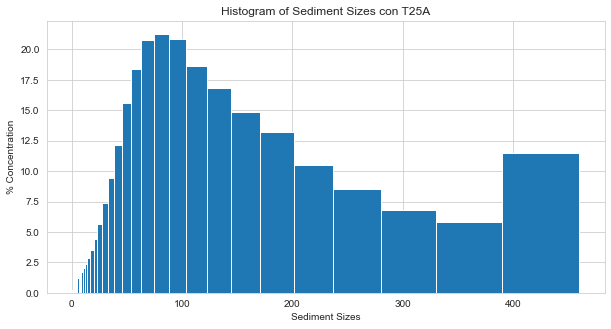

In [3]:
df = LISST_volconc['T6A']# the df to be tested for normality
sizes = LISST_volconc['Size (um)']# the sizes of the sediment

# plotting the histogram
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df, bins=sizes)
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes con T25A')
plt.show()

### plotting the histogram: equally spaced bins

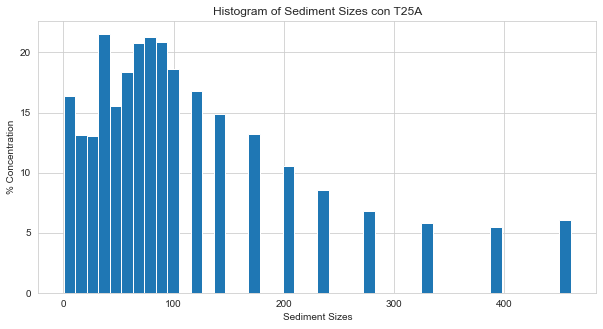

In [4]:
# plotting the histogram but equally spaced bins
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df, bins=len(sizes))
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('Histogram of Sediment Sizes con T25A')
plt.show()

It shows these spaces because there is no data that fell into the bins created

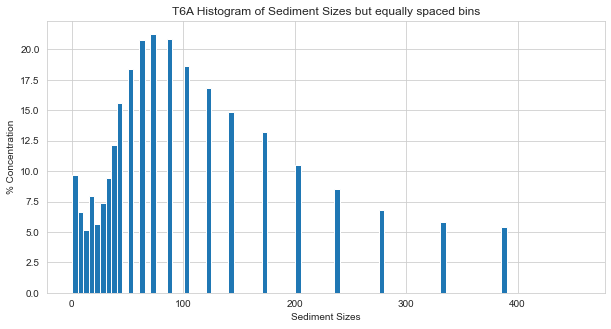

In [5]:
bins = np.arange(min(sizes), max(sizes), 5)  # custom bins (start, stop, step)

# plot of the histogram with custom bins
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.hist(sizes, weights=df, bins=bins)
plt.xlabel('Sediment Sizes')
plt.ylabel('% Concentration')
plt.title('T6A Histogram of Sediment Sizes but equally spaced bins')
plt.show()

### Q-Q plot

In [5]:
# getting percentiles
percentiles = list(range(5, 100, 1))
# setting the sizes as the index
LISST_cumconc.set_index("Size (um)", inplace=True)

# interpolate the data to calculate percentiles
percentile_LISST = pd.DataFrame() # empty df
percentile_LISST['Percentiles'] = percentiles # changing the column name
percentile_LISST.set_index("Percentiles", inplace=True) # make it the index

for column_name in LISST_cumconc.columns: 
    interp = np.interp(percentiles, LISST_cumconc[column_name], LISST_cumconc.index)
    percentile_LISST[column_name] = interp # this adds the column name and results to the new df 

percentile_LISST

,T0C,T0D,T25A,T25B,T25C,T25D,T4A,T4B,T4C,T4D,...,T5D,T6A,T6B,T6C,T6D,T7A,T7C,T7D,T8A,T8B
Percentiles,,,,,,,,,,,,,,,,,,,,,
5,8.040769,7.095970,9.794000,6.437744,9.352000,6.735000,8.465290,8.359153,6.726923,9.238197,...,6.136563,7.890000,9.133380,9.183684,8.110845,6.968154,8.415806,6.854848,6.572353,7.017869
6,10.106000,8.845000,12.442169,6.749721,12.022941,8.540000,10.003529,10.797778,8.521667,11.794444,...,7.700244,9.939600,11.327143,11.210000,9.968571,8.738636,10.573721,8.614324,8.267895,8.906709
7,12.191963,10.624902,15.007692,7.061699,14.617670,10.467204,12.321250,13.383373,10.444894,14.242261,...,9.337742,12.029091,13.475392,13.125726,11.826970,10.513689,12.672870,10.503617,10.048621,10.875532
8,14.220000,12.423525,17.437674,14.382909,17.080687,12.434071,14.561333,15.996327,12.401892,16.468348,...,11.035421,14.076698,15.540635,14.929189,13.590000,12.293040,14.640571,12.464273,11.901313,12.818142
9,16.159394,14.202213,19.786512,16.710182,19.393664,14.347092,16.694667,18.640526,14.351765,18.577103,...,12.750551,16.037405,17.523208,16.658919,15.263567,14.029040,16.469143,14.440000,13.786000,14.706761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,357.072335,366.390720,375.496652,368.573770,348.666341,334.346286,367.458642,409.156463,362.120825,376.263461,...,303.474879,313.787465,323.942174,289.834928,281.389742,322.817964,226.273010,374.873233,335.850149,293.906438
96,374.892695,382.262720,388.962715,382.512881,366.812683,355.603429,381.397752,419.379170,377.461031,389.638742,...,323.809556,338.729655,346.525378,314.197246,307.384588,345.272821,248.035000,387.618415,358.059104,316.933836
97,393.384286,400.244359,406.522551,399.376936,384.959024,376.860571,397.935680,429.601878,394.015283,407.199471,...,350.164532,368.049852,371.533782,341.680000,334.512195,370.708718,276.913378,404.970787,380.268060,344.385455


### This is incorrect, need to revisit*** 

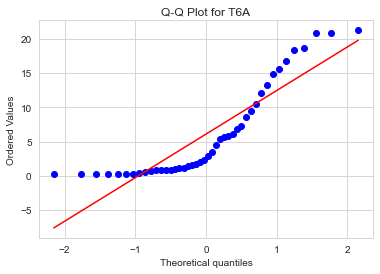

In [19]:
res = stats.probplot(df, dist="norm", plot=plt)
plt.title("Q-Q Plot for T6A")
plt.show()

### Normality Tests

In [30]:
# Assuming 'sizes' is your list of bin edges and 'df' is the concentration in each bin
# Calculate the ECDF
ecdf = np.cumsum(df)

# Generate the quantiles of the theoretical normal distribution
quantiles = np.linspace(0.01, 0.99, len(sizes))  # Avoiding 0 and 1 for the ppf

# Calculate the corresponding values for these quantiles
values = norm.ppf(quantiles)

# Generate Q-Q plot
plt.plot(values, ecdf, 'o')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')
plt.show()


NameError: name 'norm' is not defined

In [13]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
stat, p_value = kruskal(LISST_volconc['T6A'], LISST_volconc['T6B'], LISST_volconc['T6C'], LISST_volconc['T6D'])

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value}")

Kruskal-Wallis Statistic: 4.759328359329031
P-value: 0.1902927235692039


p > 0.10:
The result is not statistically significant, and there is insufficient evidence to reject the null hypothesis at the chosen significance level.